# Structure factor: Part 2

Written by Chang Woo Myung (ETHZ, USI)

In the Part 1, we explicitly calculated the Fourier component at the specific $q$ value to calculate the structure factor $S(|q|)$. Here, now we calculate the $S(q)$ in a more elegant way (I would say, but some would disagree) by using the Fast Fourier Transform (FFT) algorithm.

In [35]:
import ase
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simps
from scipy.fft import fftn, ifftn, fftfreq
import matplotlib.cm as cm
from numpy import linalg as LA
from tqdm import tqdm_notebook
from tqdm.notebook import trange,tqdm
from ase.io import read, write
from ase.neighborlist import build_neighbor_list, natural_cutoffs
from ase.build import make_supercell
import multiprocessing as mp
from multiprocessing import Pool
import os

## FFT algorithm

Among others, here we employ the discrete FFT (DFT) where the $q$-mesh grid is defined as $\frac{2\pi}{a_{lat}}\times i$ ($i=0,1,2,...,N-1$). The Fourier component ($a_q$) is then calculated as 

\begin{eqnarray}
a_q = \sum_{m=0}^{N-1} a_m e^{-i\frac{2\pi}{N}m},
\end{eqnarray}

where the real-space component is $a_m$. Here this real-space component would correspond to the atomic positions (or atomic local density).

Keep in mind that the real-space data we use defines the $q-$mesh grid spacing. If we use the unit-cell, then the $q-$mesh grid spacing would be $\frac{2\pi}{a_{lat}}$. Also, the number of grid for real-space and $q-$space are equal. Therefore, to obtain a detailed structure factor using the DFT, you need to use a large supercell structure. Here, I use a ($12 \times 12 \times 12$) supercell structure thereby using $\frac{1}{12}\frac{2\pi}{a}$ $q-$mesh grid.

### 2.1. FCC Fe crystal

In [36]:
a=read('./Fe-FCC/SPOSCAR')

alat_u=3.6456999779
sup=12
alata=alat_u*sup
alatc=alat_u*sup

N=sup*10
pos_grid=np.zeros((N+1,N+1,N+1))

rgrida=np.arange(0.0,alata+alata/N,alata/N)
rgridc=np.arange(0.0,alatc+alatc/N,alatc/N)

for i in range(a.positions.shape[0]):
    idx=np.absolute(rgrida-a.positions[i,0]).argmin()
    idy=np.absolute(rgrida-a.positions[i,1]).argmin()
    idz=np.absolute(rgridc-a.positions[i,2]).argmin()
    pos_grid[idx,idy,idz]+=1

After loading the position information of the crystal, we simply do the DFT, which is one line command.

In [37]:
#Fourier transform
Sq_fft=fftn(pos_grid)
Sq_fft=np.absolute(Sq_fft)

In [38]:
print(Sq_fft[0,0,0])
print(Sq_fft[sup,sup,sup])

6912.0
6584.0466574515685


And as we have talked about the atomic scattering factor, we add this functionality.

In [39]:
def atomic_scattering_Fe(q):
    a=[11.7695,7.3573,3.5222,2.3045]
    b=[4.7611,0.3072,15.3535,76.8805]
    c=1.0369
    
    fjq=0.0
    for ai,bi in zip(a,b):
        fjq+=ai*np.exp(-bi*q**2)
    
    return fjq+c

In [40]:
def sample_Sq(klist):
    print(alata,alatc,Sq_fft.shape)
    #q=(2*np.pi/alatc)*np.arange(0.0,10.0,0.01)
    Sqq=[]
    for i in tqdm(klist):
        for j in range(N-1):
            for k in range(N-1):
                r0=2*np.pi/alata*np.sqrt(i**2+j**2+k**2)
                r1=2*np.pi/alata*np.sqrt((i+1)**2+j**2+k**2)
                Sq=atomic_scattering_Fe(r0)*Sq_fft[i,j,k]/(4/3*np.pi*(r1**3-r0**3))
                Sqq+=[[r0,Sq]]
    return Sqq

In [41]:
num_cores=mp.cpu_count()
print("The number of cores: ",num_cores)
pool=Pool(num_cores)
klist_tot=range(N-1)
chunks=[klist_tot[i::num_cores] for i in range(num_cores)]

Sqql=[]
for Sqq_join in pool.map(sample_Sq, chunks):
    Sqql+=[Sqq_join]
pool.close()

#collect and join psiq from each core
Sqq=[]
for p in Sqql:
    for pp in p:
        Sqq.append(pp)
Sqq=np.array(Sqq)

The number of cores:  8
43.7483997348 43.7483997348 (121, 121, 121)
43.7483997348 43.7483997348 (121, 121, 121)
43.7483997348 43.7483997348 (121, 121, 121)
43.7483997348 43.7483997348 (121, 121, 121)
43.7483997348 43.7483997348 (121, 121, 121)
43.7483997348 43.7483997348 (121, 121, 121)
43.7483997348 43.7483997348 (121, 121, 121)
43.7483997348 43.7483997348 (121, 121, 121)


In [42]:
q=(2*np.pi/alat_u)*np.arange(0.0,10.0,0.01)
Sqqf=np.zeros(q.shape[0])
for i in trange(Sqq.shape[0]-1):
    j=np.abs(q-Sqq[i,0]).argmin()
    Sqqf[j]+=Sqq[i,1]

Although FFT enables a very quick calculation (and handy indeed), we also notice lots of noises in $q-$space, and these big noises could silence some of weak peaks. Thus, one should be careful interpreting the result when using the FFT.  

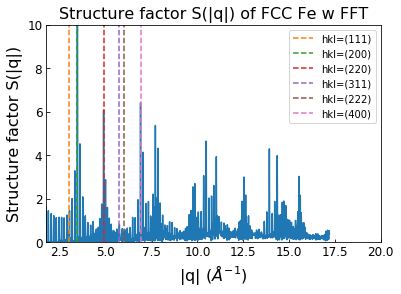

In [43]:
peak1=(2*np.pi/3.6456999779)*np.sqrt(1**2+1**2+1**2) #(1,1,1)
peak2=(2*np.pi/3.6456999779)*np.sqrt(2**2+0**2+0**2) #(2,0,0)
peak3=(2*np.pi/3.6456999779)*np.sqrt(2**2+2**2+0**2) #(2,2,0)
peak4=(2*np.pi/3.6456999779)*np.sqrt(3**2+1**2+1**2) #(3,1,1)
peak5=(2*np.pi/3.6456999779)*np.sqrt(2**2+2**2+2**2) #(2,2,2)
peak6=(2*np.pi/3.6456999779)*np.sqrt(4**2+0**2+0**2) #(4,0,0)

peaks=[
       [peak1,peak1],
       [peak2,peak2],
       [peak3,peak3],
       [peak4,peak4],
       [peak5,peak5],
       [peak6,peak6]
      ]
peak_2=[0,100000]

plt.xlim((2*np.pi/alat_u),20)
plt.ylim(0,10)
plt.tick_params(axis="y", labelsize=12, direction='in')
plt.tick_params(axis="x", labelsize=12, direction='in')

plt.title('Structure factor S(|q|) of FCC Fe w FFT',fontsize=16)
plt.xlabel('|q| ($\AA^{-1}$)', fontsize=16)
plt.ylabel('Structure factor S(|q|)', fontsize=16)


plt.plot(q[:-1],Sqqf[:-1]/2000,'-')

plt.plot(peaks[0],peak_2,'--',label='hkl=(111)')
plt.plot(peaks[1],peak_2,'--',label='hkl=(200)')
plt.plot(peaks[2],peak_2,'--',label='hkl=(220)')
plt.plot(peaks[3],peak_2,'--',label='hkl=(311)')
plt.plot(peaks[4],peak_2,'--',label='hkl=(222)')
plt.plot(peaks[5],peak_2,'--',label='hkl=(400)')

plt.legend()
plt.savefig('sq-fe-fcc-fft.png',dpi=300,bbox_inches = "tight")

### 2.2. BCC Fe crystal

In [44]:
a=read('./Fe-BCC/SPOSCAR')

alat_u=2.87
sup=12
alata=alat_u*sup
alatc=alat_u*sup

N=sup*10
pos_grid=np.zeros((N+1,N+1,N+1))

rgrida=np.arange(0.0,alata+alata/N,alata/N)
rgridc=np.arange(0.0,alatc+alatc/N,alatc/N)

for i in range(a.positions.shape[0]):
    idx=np.absolute(rgrida-a.positions[i,0]).argmin()
    idy=np.absolute(rgrida-a.positions[i,1]).argmin()
    idz=np.absolute(rgridc-a.positions[i,2]).argmin()
    pos_grid[idx,idy,idz]+=1

In [45]:
#Fourier transform
Sq_fft=fftn(pos_grid)
Sq_fft=np.absolute(Sq_fft)

In [46]:
def atomic_scattering_Fe(q):
    a=[11.7695,7.3573,3.5222,2.3045]
    b=[4.7611,0.3072,15.3535,76.8805]
    c=1.0369
    
    fjq=0.0
    for ai,bi in zip(a,b):
        fjq+=ai*np.exp(-bi*q**2)
    
    return fjq+c

In [47]:
def sample_Sq(klist):
    print(alata,alatc,Sq_fft.shape)
    #q=(2*np.pi/alatc)*np.arange(0.0,10.0,0.01)
    Sqq=[]
    for i in tqdm(klist):
        for j in range(N-1):
            for k in range(N-1):
                r0=2*np.pi/alata*np.sqrt(i**2+j**2+k**2)
                r1=2*np.pi/alata*np.sqrt((i+1)**2+j**2+k**2)
                Sq=atomic_scattering_Fe(r0)*Sq_fft[i,j,k]/(4/3*np.pi*(r1**3-r0**3))
                Sqq+=[[r0,Sq]]
    return Sqq

In [ ]:
num_cores=mp.cpu_count()
print("The number of cores: ",num_cores)
pool=Pool(num_cores)
klist_tot=range(N-1)
chunks=[klist_tot[i::num_cores] for i in range(num_cores)]

Sqql=[]
for Sqq_join in pool.map(sample_Sq, chunks):
    Sqql+=[Sqq_join]
pool.close()

#collect and join psiq from each core
Sqq=[]
for p in Sqql:
    for pp in p:
        Sqq.append(pp)
Sqq=np.array(Sqq)

The number of cores:  8
34.44 34.44 (121, 121, 121)
34.44 34.44 (121, 121, 121)
34.44 34.44 (121, 121, 121)
34.44 34.44 (121, 121, 121)
34.44 34.44 (121, 121, 121)
34.44 34.44 (121, 121, 121)
34.44 34.44 (121, 121, 121)
34.44 34.44 (121, 121, 121)


In [ ]:
q=(2*np.pi/alat_u)*np.arange(0.0,10.0,0.01)
Sqqf=np.zeros(q.shape[0])
for i in trange(Sqq.shape[0]-1):
    j=np.abs(q-Sqq[i,0]).argmin()
    Sqqf[j]+=Sqq[i,1]

In [ ]:
peak1=(2*np.pi/alat_u)*np.sqrt(1**2+1**2+0**2) #(1,1,0)
peak2=(2*np.pi/alat_u)*np.sqrt(2**2+0**2+0**2) #(2,0,0)
peak3=(2*np.pi/alat_u)*np.sqrt(2**2+1**2+1**2) #(2,1,1)
peak4=(2*np.pi/alat_u)*np.sqrt(2**2+2**2+0**2) #(2,2,0)
peak5=(2*np.pi/alat_u)*np.sqrt(3**2+1**2+0**2) #(3,1,0)
peak6=(2*np.pi/alat_u)*np.sqrt(2**2+2**2+2**2) #(2,2,2)

peaks=[
       [peak1,peak1],
       [peak2,peak2],
       [peak3,peak3],
       [peak4,peak4],
       [peak5,peak5],
       [peak6,peak6]
      ]
peak_2=[0,100000]

plt.xlim((2*np.pi/alat_u),20)
plt.ylim(0,4)
plt.tick_params(axis="y", labelsize=12, direction='in')
plt.tick_params(axis="x", labelsize=12, direction='in')

plt.title('Structure factor S(|q|) of BCC Fe w FFT',fontsize=16)
plt.xlabel('|q| ($\AA^{-1}$)', fontsize=16)
plt.ylabel('Structure factor S(|q|)', fontsize=16)


plt.plot(q[:-1],Sqqf[:-1]/2000,'-')

plt.plot(peaks[0],peak_2,'--',label='hkl=(110)')
plt.plot(peaks[1],peak_2,'--',label='hkl=(200)')
plt.plot(peaks[2],peak_2,'--',label='hkl=(211)')
plt.plot(peaks[3],peak_2,'--',label='hkl=(220)')
plt.plot(peaks[4],peak_2,'--',label='hkl=(310)')
plt.plot(peaks[5],peak_2,'--',label='hkl=(222)')

plt.legend()
plt.savefig('sq-fe-bcc-fft.png',dpi=300,bbox_inches = "tight")